In [1]:
from backtest import *
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from keras.models import Sequential
from keras.models import Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Permute, Reshape
from keras.layers import Merge, Input, concatenate, GaussianNoise
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.layers import Convolution1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, RepeatVector, AveragePooling1D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.layers.wrappers import Bidirectional, TimeDistributed
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *
from keras.constraints import *
from keras import regularizers
from keras import losses

from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef

/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
symbol = 'LTC1518'
bars = pd.read_csv('./data/%s.csv' % symbol, header=0, parse_dates=['Date'])

In [3]:
START_TRAIN_DATE = '2015-01-01'
END_TRAIN_DATE = '2017-12-31'
START_TEST_DATE = '2018-01-01'
END_TEST_DATE = '2018-03-09'
LOOKBACK = 7
STEP = 1
FORECAST = 1
INIT_CAPITAL = 10000
STAKE = 10

In [4]:
train_set = bars[(bars['Date'] > START_TRAIN_DATE) & (bars['Date'] < END_TRAIN_DATE)]

In [5]:
test_set = bars[(bars['Date'] > START_TEST_DATE) & (bars['Date'] < END_TEST_DATE)]

In [6]:
def create_dataset(data):
    
    highp = pd.to_numeric(data.ix[:, 'High'])
    lowp = pd.to_numeric(data.ix[:, 'Low'])
    openp = pd.to_numeric(data.ix[:, 'Open'])
    closep = pd.to_numeric(data.ix[:, 'Close'])
    tradesp = pd.to_numeric(data.ix[:, 'Trades'])
    volumep = pd.to_numeric(data.ix[:, 'Volume'])

    normal_close = closep.values.tolist()
    normal_open = openp.values.tolist()

    highp = highp.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    lowp = lowp.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    openp = openp.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    closep = closep.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    tradesp = tradesp.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    volumep = volumep.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()

    X, Y = [], []
    
    for i in range(0, len(data), STEP): 
        try:
            o = openp[i:i+LOOKBACK]
            h = highp[i:i+LOOKBACK]
            l = lowp[i:i+LOOKBACK]
            c = closep[i:i+LOOKBACK]
            v = volumep[i:i+LOOKBACK]
            t = tradesp[i:i+LOOKBACK]

            y_i = (normal_close[i+LOOKBACK+FORECAST] - normal_open[i+LOOKBACK]) / normal_open[i+LOOKBACK]
            y_i = 1 if y_i > 0 else 0
            
            x_i = np.column_stack((o, h, l, c, v, t))
    
        except Exception as e:
            break

        X.append(x_i)
        Y.append(y_i)

    X, Y = np.array(X), np.array(Y)
    return X, Y

In [7]:
X_train, Y_train = create_dataset(train_set)
X_test, Y_test = create_dataset(test_set)

In [8]:
def plot_history(history):
    # summarize history for accuracy
    plt.subplot(2, 1, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.axhline(y=0.5, color='grey', linestyle='--')
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.axhline(y=0.693, color='grey', linestyle='--')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [9]:
def get_lr_model(x1, x2):
    main_input = Input(shape=(x1, x2, ), name='main_input')
    x = GaussianNoise(0.01)(main_input)
    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation = "sigmoid", name = "out")(x)
    final_model = Model(inputs=[main_input], outputs=[output])
    final_model.compile(optimizer=Adam(lr=0.001, amsgrad=True),  loss='binary_crossentropy', metrics = ['accuracy'])
    return final_model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 7, 6)              0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 7, 6)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 42)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 42)                168       
_________________________________________________________________
dropout_1 (Dropout)          (None, 42)                0         
_________________________________________________________________
out (Dense)                  (None, 1)                 43        
Total params: 211
Trainable params: 127
Non-trainable params: 84
_________________________________________________________________


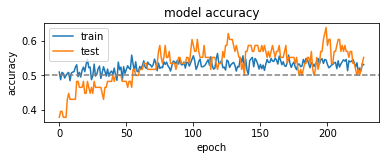

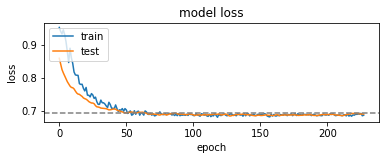

MATTHEWS CORRELATION
0.20787157232053555
CONFUSION MATRIX
[[0.42857143 0.53333333]
 [0.25       0.76666667]]
CLASSIFICATION REPORT
             precision    recall  f1-score   support

          0       0.63      0.43      0.51        28
          1       0.59      0.77      0.67        30

avg / total       0.61      0.60      0.59        58

--------------------


In [10]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=50, min_lr=0.000001, verbose=0)
checkpointer = ModelCheckpoint(filepath="testtest.hdf5", verbose=0, save_best_only=True)
es = EarlyStopping(patience=100)

model = get_lr_model(X_train.shape[1], X_train.shape[-1])
# model = get_model(X_train.shape[1], X_train.shape[-1])
model.summary()

history = model.fit(X_train, Y_train, 
              epochs = 1000, 
              batch_size = 64, 
              verbose=0, 
              validation_data=(X_test, Y_test),
              callbacks=[reduce_lr, checkpointer, es],
              shuffle=True)

model.load_weights('testtest.hdf5')
pred = model.predict(X_test)
plot_history(history)

pred = [1 if p > 0.5 else 0 for p in pred]
C = confusion_matrix(Y_test, pred)

print 'MATTHEWS CORRELATION'
print matthews_corrcoef(Y_test, pred)
print 'CONFUSION MATRIX'
print(C / C.astype(np.float).sum(axis=1))
print 'CLASSIFICATION REPORT'
print classification_report(Y_test, pred)
print '-' * 20

In [11]:
pred = [1 if p == 1 else -1 for p in pred] # we need to change NN's 0 output to -1 for our strategy
pred = [p if i % FORECAST == 0 else 0 for i, p in enumerate(pred)]
pred = [0.] * (LOOKBACK) + pred + [0] * FORECAST# first LOOKBACK items needed to make first forecast + items we shifted

In [12]:
class MachineLearningForecastingStrategy(Strategy):   
    
    def __init__(self, symbol, bars, pred):
        self.symbol = symbol
        self.bars = bars

    def generate_signals(self):
        signals = pd.DataFrame(index=self.bars.index)
        signals['signal'] = pred
        return signals

In [13]:
# preparing for forecasting for tomorrow!
test_set['Close'] = test_set['Close'].shift(-FORECAST)

rfs = MachineLearningForecastingStrategy('LTC', test_set, pred)
signals = rfs.generate_signals()
portfolio = MarketIntradayPortfolio('LTC', test_set, signals, INIT_CAPITAL, STAKE)
returns = portfolio.backtest_portfolio()

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [14]:
returns['signal'] = signals
our_pct_growth = returns['total'].pct_change().cumsum()
benchmark_ptc_growth = test_set['Close'].pct_change().cumsum()

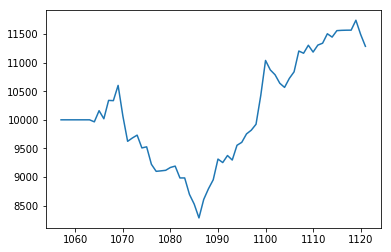

In [15]:
plt.figure()
plt.plot(returns['total'])
plt.show()

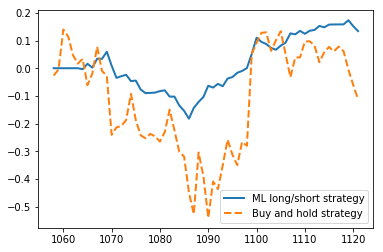

In [16]:
plt.figure()
plt.plot(our_pct_growth, label = 'ML long/short strategy', linewidth=2)
plt.plot(benchmark_ptc_growth, linestyle = '--', label = 'Buy and hold strategy', linewidth=2)
plt.legend()
plt.show()

In [17]:
def sharpe(returns):
    return np.sqrt(len(returns)) * returns.mean() / returns.std()

In [18]:
print sharpe(our_pct_growth)
print sharpe(benchmark_ptc_growth)

1.1939465976910248
-4.686132793354552


In [19]:
returns.tail()

,price_diff,profit,total,returns,signal
1118,0.08,0.8,11568.0,0.000069,1.0
1119,-17.33,173.3,11741.3,0.014981,-1.0
1120,-24.85,-248.5,11492.8,-0.021165,1.0
1121,-20.74,-207.4,11285.4,-0.018046,1.0
1122,NaN,NaN,NaN,NaN,0.0
